In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audio-dataset/audio_only_ID_9.wav
/kaggle/input/audio-dataset/audio_only_ID_29.wav
/kaggle/input/audio-dataset/audio_only_ID_21.wav
/kaggle/input/audio-dataset/audio_only_ID_34.wav
/kaggle/input/audio-dataset/audio_only_ID_41.wav
/kaggle/input/audio-dataset/audio_only_ID_15.wav
/kaggle/input/audio-dataset/audio_only_ID_14.wav
/kaggle/input/audio-dataset/audio_only_ID_18.wav
/kaggle/input/audio-dataset/audio_only_ID_7.wav
/kaggle/input/audio-dataset/audio_only_ID_40.wav
/kaggle/input/audio-dataset/audio_only_ID_6.wav
/kaggle/input/audio-dataset/audio_only_ID_45.wav
/kaggle/input/audio-dataset/audio_only_ID_28.wav
/kaggle/input/audio-dataset/audio_only_ID_20.wav
/kaggle/input/audio-dataset/audio_only_ID_10.wav
/kaggle/input/audio-dataset/audio_only_ID_19.wav
/kaggle/input/audio-dataset/audio_only_ID_38.wav
/kaggle/input/audio-dataset/audio_only_ID_23.wav
/kaggle/input/audio-dataset/audio_only_ID_4.wav
/kaggle/input/audio-dataset/audio_only_ID_13.wav
/kaggle/input/audio-data

In [5]:
pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512551 sha256=a14ebf6a6735fcdc3afb16b21195c5c4c06f2a2dd45ef597ebb01f40e7e58836
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


In [6]:
import cv2
import numpy as np
import librosa
import librosa.display
import scipy.signal
import os
import IPython.display as ipd
import random
import warnings
from moviepy.editor import VideoFileClip
from tqdm import tqdm
import pandas as pd
import librosa
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.signal import iirfilter, lfilter, find_peaks
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from itertools import product
from moviepy.editor import VideoFileClip, AudioFileClip
from scipy.signal import correlate
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linear_sum_assignment
import shutil

In [7]:
warnings.filterwarnings("ignore")

In [8]:
audio_folder = "/kaggle/input/audio-dataset"
video_folder = "/kaggle/input/video-dataset"

In [9]:
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav") or f.endswith(".mp3")]
video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]

In [10]:
selected_audio = random.sample(audio_files, 2)
selected_video = random.sample(video_files, 2)

In [11]:
for audio in selected_audio:
    print(audio)
    audio_path = os.path.join(audio_folder, audio)
    display(ipd.Audio(audio_path))

audio_only_ID_42.wav


audio_only_ID_9.wav


In [12]:
print("\nSelected Video Files:")
for video in selected_video:
    print(video)
    clip = VideoFileClip(os.path.join(video_folder, video))
    display(clip.ipython_display(width=400))


Selected Video Files:
video_only_ID_29.mp4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


video_only_ID_6.mp4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [13]:
video_path = "/kaggle/input/video-dataset/video_only_ID_14.mp4"
output_path = "/kaggle/working/tracked_video.mp4"

In [14]:
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([140, 255, 255])
box_x_min, box_y_min = 80, 60
box_x_max, box_y_max = 575, 420

In [15]:
cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, 60.0, (640, 480))

frame_number = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    frame_resized = cv2.resize(frame, (640, 480))
    hsv = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.rectangle(frame_resized, (box_x_min, box_y_min), (box_x_max, box_y_max), (0, 255, 0), 2) 

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        x, y, radius = int(x), int(y), int(radius)
    if radius > 5:
        cv2.circle(frame, (x, y), radius, (0, 255, 0), 3)
        cv2.circle(frame_resized, (x, y), 2, (0, 0, 255), 3)  

    out.write(frame_resized)

cap.release()
out.release()

In [16]:
clip = VideoFileClip(os.path.join("/kaggle/working/tracked_video.mp4"))
display(clip.ipython_display(width=600))

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [17]:
tracking_data = []

In [18]:
for video_file in tqdm(video_files, desc="Processing Videos"):
    video_path = os.path.join(video_folder, video_file)
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)  
    duration_per_frame = 1 / fps  

    frame_number = 0  

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        frame_resized = cv2.resize(frame, (640, 480))
        hsv = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower_blue, upper_blue)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            (x, y), radius = cv2.minEnclosingCircle(largest_contour)
            x, y, radius = int(x), int(y), int(radius)

            timestamp = frame_number * duration_per_frame  
            tracking_data.append([video_file, frame_number, timestamp, x, y, radius])

    cap.release()


Processing Videos: 100%|██████████| 45/45 [02:43<00:00,  3.63s/it]


In [19]:
df_tracking = pd.DataFrame(tracking_data, columns=["Video", "Frame", "Timestamp", "X", "Y", "Radius"])

In [20]:
df_tracking = df_tracking.sort_values(by=["Video", "Frame"], ascending=[True, True]).reset_index(drop=True)

In [21]:
df_tracking.head()

,Video,Frame,Timestamp,X,Y,Radius
0,video_only_ID_1.mp4,1,0.016667,328,238,8
1,video_only_ID_1.mp4,2,0.033333,341,237,8
2,video_only_ID_1.mp4,3,0.050000,354,233,8
3,video_only_ID_1.mp4,4,0.066667,366,231,8
4,video_only_ID_1.mp4,5,0.083333,379,230,8


In [22]:
len(df_tracking.Video.unique())

45

In [23]:
df_tracking.shape

(48741, 6)

In [24]:
collision_data = []

In [25]:
for video_file in df_tracking["Video"].unique():
    df_video = df_tracking[df_tracking["Video"] == video_file]

    prev_x, prev_y, prev_r = None, None, None

    for index, row in df_video.iterrows():
        x, y, r, timestamp = row["X"], row["Y"], row["Radius"], row["Timestamp"]

        if prev_x is not None and prev_y is not None and prev_r is not None:
            crossed_left = (prev_x - prev_r > box_x_min) and ((x - r) <= box_x_min)
            crossed_right = (prev_x + prev_r < box_x_max) and ((x + r) >= box_x_max)
            crossed_bottom = (prev_y + prev_r < box_y_max) and ((y + r) >= box_y_max)

            if crossed_left or crossed_right or crossed_bottom:
                collision_data.append([video_file, row["Frame"], timestamp, x, y])

        prev_x, prev_y, prev_r = x, y, r  


In [26]:
df_collision = pd.DataFrame(collision_data, columns=["Video", "Frame", "Timestamp", "X", "Y"])

In [27]:
df_collision = df_collision.sort_values(by=["Video", "Frame"], ascending=[True, True]).reset_index(drop=True)

In [28]:
len(df_collision.Video.unique())

45

In [29]:
df_collision.head()

,Video,Frame,Timestamp,X,Y
0,video_only_ID_1.mp4,20,0.333333,571,210
1,video_only_ID_1.mp4,60,1.000000,86,266
2,video_only_ID_1.mp4,90,1.500000,443,412
3,video_only_ID_1.mp4,100,1.666667,571,377
4,video_only_ID_1.mp4,140,2.333333,85,230


In [30]:
df_collision.shape

(909, 5)

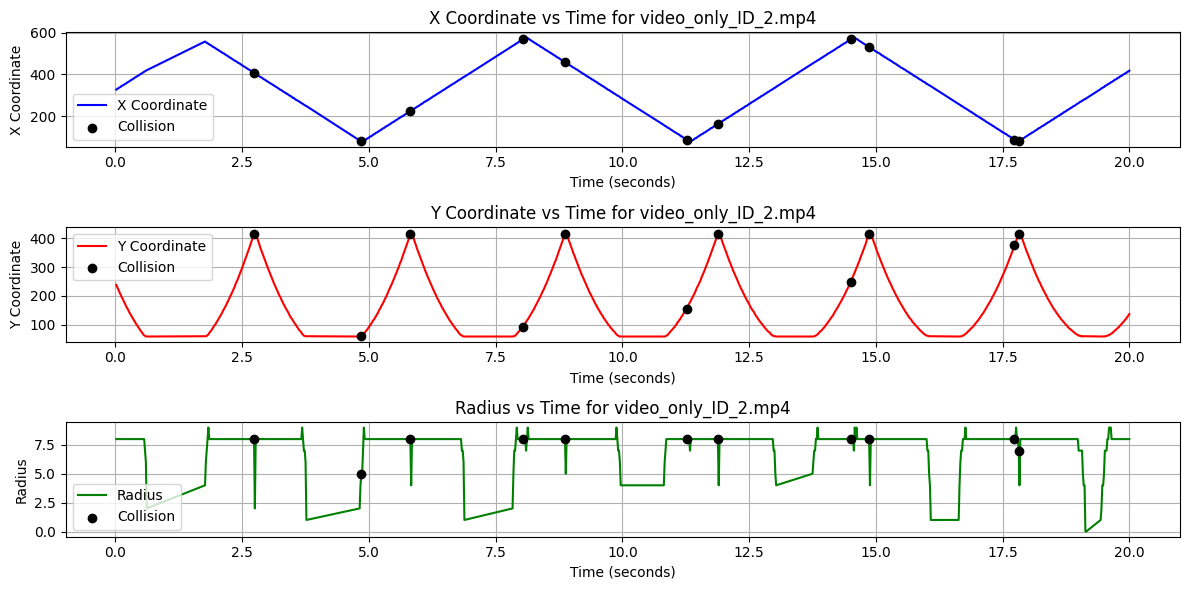

In [31]:

video_name = "video_only_ID_2.mp4"

df_video = df_tracking[df_tracking["Video"] == video_name]

time_stamps = df_video["Timestamp"]
x_coords = df_video["X"]
y_coords = df_video["Y"]
radii = df_video["Radius"]

df_collisions_video = df_collision[df_collision["Video"] == video_name]
collision_times = df_collisions_video["Timestamp"]
collision_x = df_collisions_video["X"]
collision_y = df_collisions_video["Y"]

plt.figure(figsize=(12, 6))


plt.subplot(3, 1, 1)
plt.plot(time_stamps, x_coords, color='blue', label="X Coordinate")
plt.scatter(collision_times, collision_x, color='black', marker='o', label="Collision", zorder=3)
plt.xlabel("Time (seconds)")
plt.ylabel("X Coordinate")
plt.title(f"X Coordinate vs Time for {video_name}")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time_stamps, y_coords, color='red', label="Y Coordinate")
plt.scatter(collision_times, collision_y, color='black', marker='o', label="Collision", zorder=3)
plt.xlabel("Time (seconds)")
plt.ylabel("Y Coordinate")
plt.title(f"Y Coordinate vs Time for {video_name}")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(time_stamps, radii, color='green', label="Radius")
plt.scatter(collision_times, [radii.iloc[time_stamps.searchsorted(t)] for t in collision_times], 
            color='black', marker='o', label="Collision", zorder=3)
plt.xlabel("Time (seconds)")
plt.ylabel("Radius")
plt.title(f"Radius vs Time for {video_name}")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

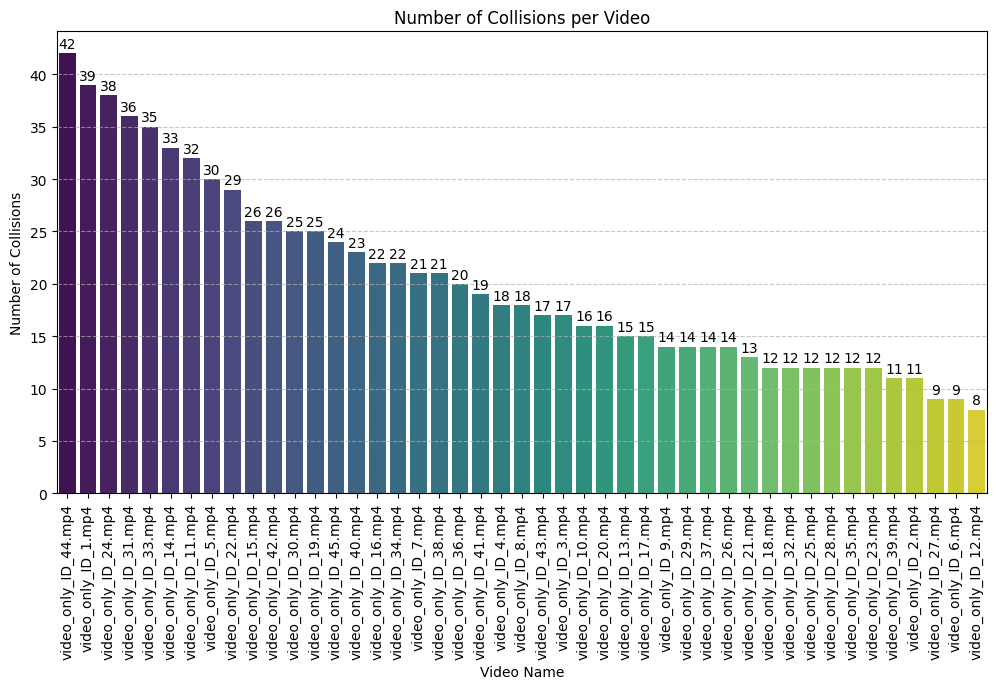

In [32]:
collision_counts = df_collision["Video"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=collision_counts.index, y=collision_counts.values, palette="viridis")

plt.xlabel("Video Name")
plt.ylabel("Number of Collisions")
plt.title("Number of Collisions per Video")
plt.xticks(rotation=90) 
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, count in enumerate(collision_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)


plt.show()

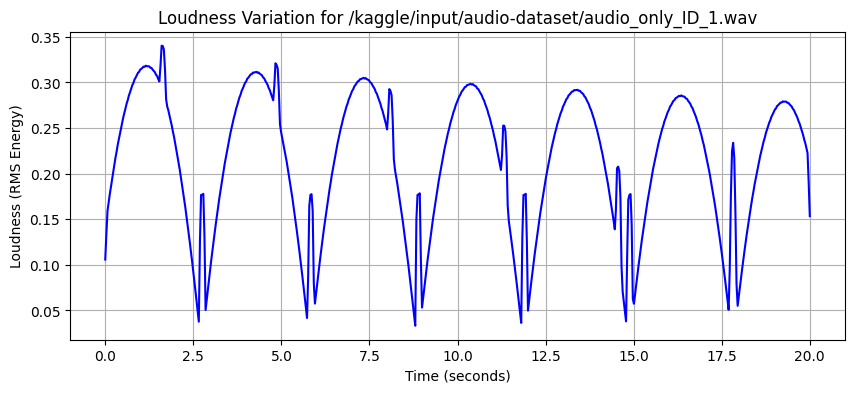

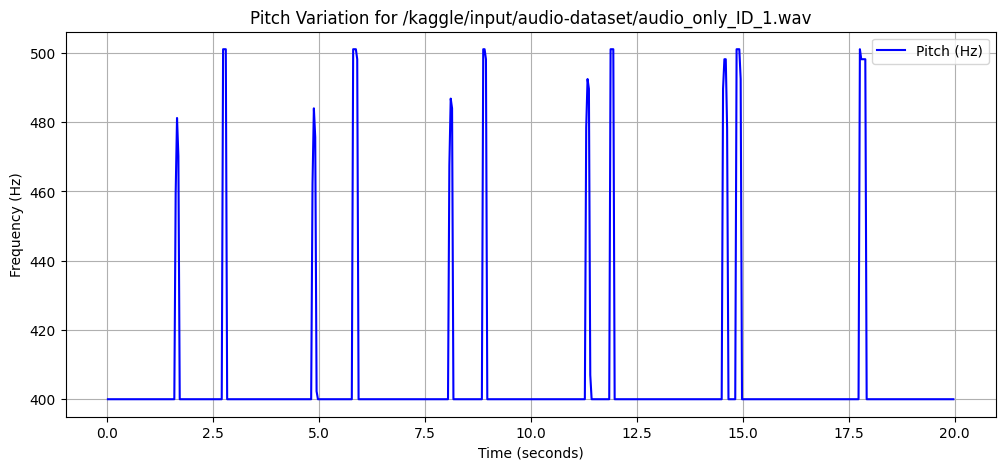

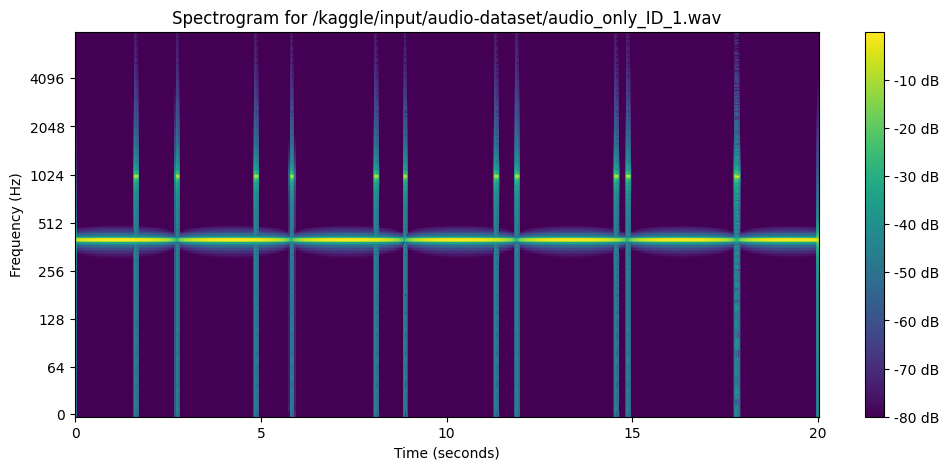

In [33]:
audio_file = "/kaggle/input/audio-dataset/audio_only_ID_1.wav"


y, sr = librosa.load(audio_file, sr=None)

rms = librosa.feature.rms(y=y)[0]

time_axis = librosa.frames_to_time(np.arange(len(rms)), sr=sr)

plt.figure(figsize=(10, 4))
plt.plot(time_axis, rms, color="b")
plt.xlabel("Time (seconds)")
plt.ylabel("Loudness (RMS Energy)")
plt.title(f"Loudness Variation for {audio_file}")
plt.grid()
plt.show()


f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=100, fmax=3000, sr=sr)

time_axis = np.arange(len(f0)) * (len(y) / sr / len(f0))

plt.figure(figsize=(12, 5))
plt.plot(time_axis, f0, label="Pitch (Hz)", color="b")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Pitch Variation for {audio_file}")
plt.legend()
plt.grid()
plt.show()


D = np.abs(librosa.stft(y))

D_db = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(12, 5))
librosa.display.specshow(D_db, sr=sr, x_axis="time", y_axis="log", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Spectrogram for {audio_file}")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

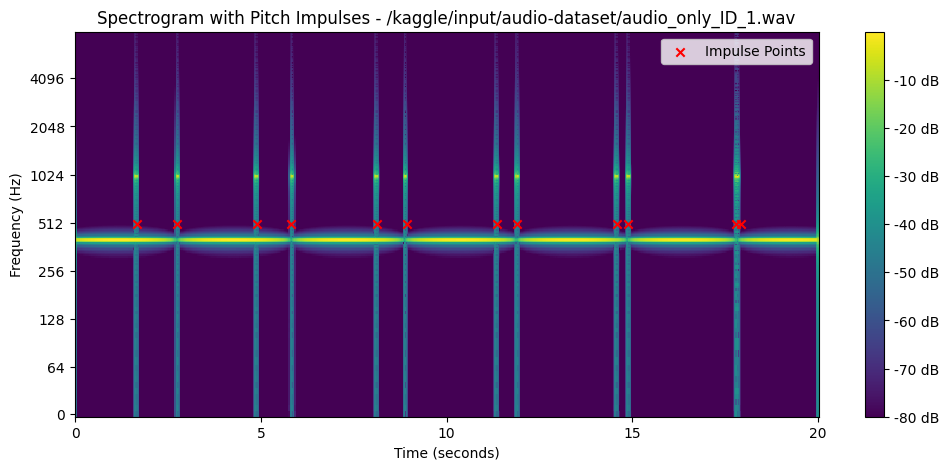

In [34]:
audio_file = "/kaggle/input/audio-dataset/audio_only_ID_1.wav"
y, sr = librosa.load(audio_file, sr=None)

f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=100, fmax=3000, sr=sr)

time_axis = librosa.frames_to_time(np.arange(len(f0)), sr=sr)

f0 = np.nan_to_num(f0, nan=np.nanmean(f0))

b, a = signal.iirfilter(N=4, Wn=0.01, btype="high", ftype="butter", output="ba")
filtered_f0 = signal.filtfilt(b, a, f0)

impulse_indices = signal.find_peaks(np.abs(filtered_f0), height=np.percentile(np.abs(filtered_f0), 95))[0]
impulse_times = time_axis[impulse_indices]

D = np.abs(librosa.stft(y))
D_db = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(12, 5))
librosa.display.specshow(D_db, sr=sr, x_axis="time", y_axis="log", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Spectrogram with Pitch Impulses - {audio_file}")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")

plt.scatter(impulse_times, [500] * len(impulse_times), color='red', marker='x', label='Impulse Points')
plt.legend()
plt.show()


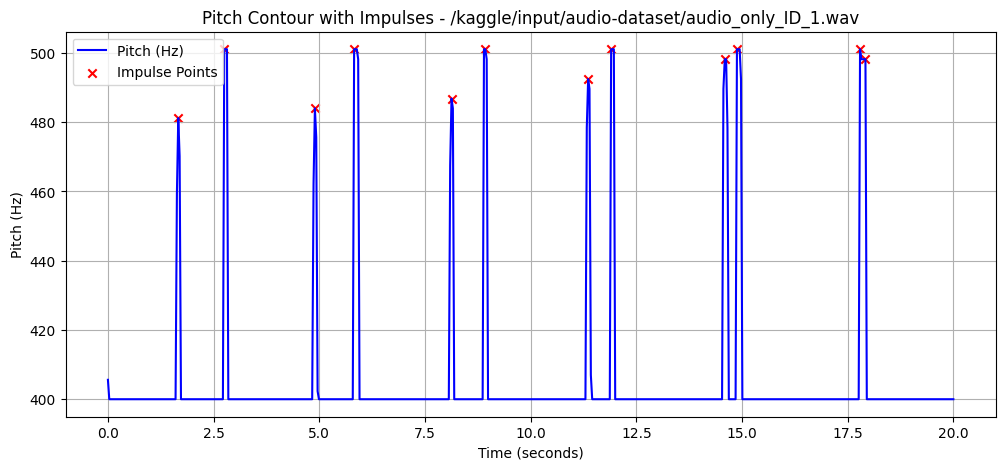

In [35]:
audio_file = "/kaggle/input/audio-dataset/audio_only_ID_1.wav"
y, sr = librosa.load(audio_file, sr=None)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=100, fmax=5000, sr=sr)
time_axis = librosa.frames_to_time(np.arange(len(f0)), sr=sr)
f0 = np.nan_to_num(f0, nan=np.nanmean(f0))
b, a = signal.iirfilter(N=4, Wn=0.01, btype="high", ftype="butter", output="ba")
filtered_f0 = signal.filtfilt(b, a, f0)
impulse_indices = signal.find_peaks(np.abs(filtered_f0), height=np.percentile(np.abs(filtered_f0), 95))[0]
impulse_times = time_axis[impulse_indices]
impulse_pitches = f0[impulse_indices]

plt.figure(figsize=(12, 5))
plt.plot(time_axis, f0, label="Pitch (Hz)", color="b")
plt.scatter(impulse_times, impulse_pitches, color='red', marker='x', label='Impulse Points')
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz)")
plt.title(f"Pitch Contour with Impulses - {audio_file}")
plt.legend()
plt.grid()
plt.show()

In [36]:
pitch_impulse_data = {"Audio": [], "Timestamp": []}

In [37]:
for audio_file in tqdm(os.listdir(audio_folder), desc="Processing Audio Files", unit="file"):
    if audio_file.endswith(".wav"):  
        audio_path = os.path.join(audio_folder, audio_file)        
        y, sr = librosa.load(audio_path, sr=None)

        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=100, fmax=5000, sr=sr)

        time_axis = librosa.frames_to_time(np.arange(len(f0)), sr=sr)
        
        f0 = np.nan_to_num(f0, nan=np.nanmean(f0))
        b, a = signal.iirfilter(N=4, Wn=0.01, btype="high", ftype="butter", output="ba")
        filtered_f0 = signal.filtfilt(b, a, f0)
        impulse_indices = signal.find_peaks(np.abs(filtered_f0), height=np.percentile(np.abs(filtered_f0), 90))[0]
        impulse_times = time_axis[impulse_indices]
        impulse_pitches = f0[impulse_indices]

        for t in impulse_times:
            pitch_impulse_data["Audio"].append(audio_file)
            pitch_impulse_data["Timestamp"].append(t)

Processing Audio Files: 100%|██████████| 45/45 [04:06<00:00,  5.47s/file]


In [38]:
df_pitch = pd.DataFrame(pitch_impulse_data)

In [39]:
df_pitch  = df_pitch.sort_values(by=["Audio", "Timestamp"], ascending=[True, True]).reset_index(drop=True)

In [40]:
df_pitch.head()

,Audio,Timestamp
0,audio_only_ID_1.wav,1.664
1,audio_only_ID_1.wav,2.752
2,audio_only_ID_1.wav,4.896
3,audio_only_ID_1.wav,5.824
4,audio_only_ID_1.wav,8.128


In [41]:
df_pitch.shape

(853, 2)

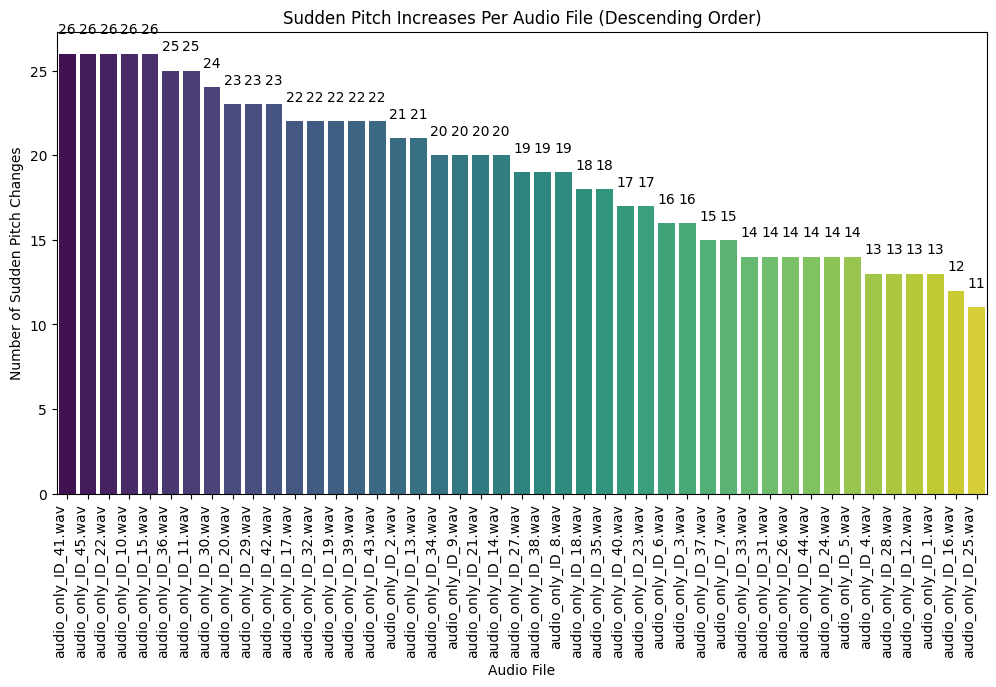

In [42]:
pitch_counts = df_pitch["Audio"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=pitch_counts.index, y=pitch_counts.values, palette="viridis")

plt.xlabel("Audio File")
plt.ylabel("Number of Sudden Pitch Changes")
plt.title("Sudden Pitch Increases Per Audio File (Descending Order)")
plt.xticks(rotation=90, ha="right")

for i, count in enumerate(pitch_counts.values):
    plt.text(i, count + 1, str(count), ha="center", va="bottom", fontsize=10)

plt.show()

In [43]:
def match_audio_video(audio_files, video_files, df_pitch, df_collision):
    best_matches = {}
    distance_matrix = []

    nn_audio = NearestNeighbors(n_neighbors=1, metric='euclidean')
    
    for audio_file in audio_files:
        audio_times = np.unique(df_pitch[df_pitch["Audio"] == audio_file]["Timestamp"].values)
        nn_audio.fit(audio_times.reshape(-1, 1))

        audio_distances = []
        for video_file in video_files:
            video_times = np.unique(df_collision[df_collision["Video"] == video_file]["Timestamp"].values)

            distances, _ = nn_audio.kneighbors(video_times.reshape(-1, 1))

            mean_distance = np.mean(distances)
            audio_distances.append(mean_distance)

        distance_matrix.append(audio_distances)

    distance_matrix = np.array(distance_matrix)

    row_ind, col_ind = linear_sum_assignment(distance_matrix)

    for audio_idx, video_idx in zip(row_ind, col_ind):
        audio_file = audio_files[audio_idx]
        video_file = video_files[video_idx]
        best_matches[audio_file] = video_file

    return best_matches

In [44]:
final_mapping = match_audio_video(audio_files, video_files, df_pitch, df_collision)

In [45]:
print("Final Audio-Video Mapping:")
for audio, video in final_mapping.items():
    print(f"{audio} -> {video}")

Final Audio-Video Mapping:
audio_only_ID_9.wav -> video_only_ID_36.mp4
audio_only_ID_29.wav -> video_only_ID_30.mp4
audio_only_ID_21.wav -> video_only_ID_26.mp4
audio_only_ID_34.wav -> video_only_ID_41.mp4
audio_only_ID_41.wav -> video_only_ID_22.mp4
audio_only_ID_15.wav -> video_only_ID_38.mp4
audio_only_ID_14.wav -> video_only_ID_7.mp4
audio_only_ID_18.wav -> video_only_ID_4.mp4
audio_only_ID_7.wav -> video_only_ID_37.mp4
audio_only_ID_40.wav -> video_only_ID_3.mp4
audio_only_ID_6.wav -> video_only_ID_13.mp4
audio_only_ID_45.wav -> video_only_ID_1.mp4
audio_only_ID_28.wav -> video_only_ID_25.mp4
audio_only_ID_20.wav -> video_only_ID_11.mp4
audio_only_ID_10.wav -> video_only_ID_42.mp4
audio_only_ID_19.wav -> video_only_ID_5.mp4
audio_only_ID_38.wav -> video_only_ID_8.mp4
audio_only_ID_23.wav -> video_only_ID_10.mp4
audio_only_ID_4.wav -> video_only_ID_21.mp4
audio_only_ID_13.wav -> video_only_ID_14.mp4
audio_only_ID_16.wav -> video_only_ID_18.mp4
audio_only_ID_2.wav -> video_only_ID_1

In [47]:
submission = pd.read_csv("/kaggle/input/csv-file/submit_solution_mapping.csv")

In [48]:
for idx, row in submission.iterrows():
    audio_file = row['AUDIO']
    if audio_file in final_mapping:
        submission.at[idx, 'VIDEO'] = final_mapping[audio_file]

In [49]:
submission.head()

,AUDIO,VIDEO
0,audio_only_ID_6.wav,video_only_ID_13.mp4
1,audio_only_ID_34.wav,video_only_ID_41.mp4
2,audio_only_ID_27.wav,video_only_ID_40.mp4
3,audio_only_ID_29.wav,video_only_ID_30.mp4
4,audio_only_ID_41.wav,video_only_ID_22.mp4


In [50]:
len(submission.VIDEO.unique())

45

In [51]:
len(submission.AUDIO.unique())

45

In [52]:
first_row = submission.iloc[6]
video_path = first_row['VIDEO']
audio_path = first_row['AUDIO']

audio_path = os.path.join(audio_folder,audio_path)
video_path = os.path.join(video_folder,video_path)

video_clip = VideoFileClip(video_path)
audio_clip = AudioFileClip(audio_path)
video_clip = video_clip.set_audio(audio_clip)
display(video_clip.ipython_display(width=600))

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [53]:
output_folder = '/kaggle/working/combined_video/'
os.makedirs(output_folder, exist_ok=True)

In [54]:
for idx, row in submission.iterrows():
    audio_file = row['AUDIO']
    video_file = row['VIDEO']

    audio_path = os.path.join(audio_folder, audio_file)
    video_path = os.path.join(video_folder, video_file)

    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_path)

    video_clip = video_clip.set_audio(audio_clip)
    output_video_path = os.path.join(output_folder, f'combined_{audio_file.split(".")[0]}.mp4')

    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_6.mp4.
MoviePy - Writing audio in combined_audio_only_ID_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_6.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_6.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_34.mp4.
MoviePy - Writing audio in combined_audio_only_ID_34TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_34.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_34.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_27.mp4.
MoviePy - Writing audio in combined_audio_only_ID_27TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_27.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_27.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_29.mp4.
MoviePy - Writing audio in combined_audio_only_ID_29TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_29.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_29.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_41.mp4.
MoviePy - Writing audio in combined_audio_only_ID_41TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_41.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_41.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_13.mp4.
MoviePy - Writing audio in combined_audio_only_ID_13TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_13.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_13.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_32.mp4.
MoviePy - Writing audio in combined_audio_only_ID_32TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_32.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_32.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_45.mp4.
MoviePy - Writing audio in combined_audio_only_ID_45TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_45.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_45.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_36.mp4.
MoviePy - Writing audio in combined_audio_only_ID_36TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_36.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_36.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_44.mp4.
MoviePy - Writing audio in combined_audio_only_ID_44TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_44.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_44.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_40.mp4.
MoviePy - Writing audio in combined_audio_only_ID_40TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_40.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_40.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_9.mp4.
MoviePy - Writing audio in combined_audio_only_ID_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_9.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_9.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_2.mp4.
MoviePy - Writing audio in combined_audio_only_ID_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_2.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_2.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_30.mp4.
MoviePy - Writing audio in combined_audio_only_ID_30TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_30.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_30.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_19.mp4.
MoviePy - Writing audio in combined_audio_only_ID_19TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_19.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_19.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_20.mp4.
MoviePy - Writing audio in combined_audio_only_ID_20TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_20.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_20.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_43.mp4.
MoviePy - Writing audio in combined_audio_only_ID_43TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_43.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_43.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_11.mp4.
MoviePy - Writing audio in combined_audio_only_ID_11TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_11.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_11.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_7.mp4.
MoviePy - Writing audio in combined_audio_only_ID_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_7.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_7.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_23.mp4.
MoviePy - Writing audio in combined_audio_only_ID_23TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_23.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_23.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_18.mp4.
MoviePy - Writing audio in combined_audio_only_ID_18TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_18.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_18.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_14.mp4.
MoviePy - Writing audio in combined_audio_only_ID_14TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_14.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_14.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_17.mp4.
MoviePy - Writing audio in combined_audio_only_ID_17TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_17.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_17.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_39.mp4.
MoviePy - Writing audio in combined_audio_only_ID_39TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_39.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_39.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_10.mp4.
MoviePy - Writing audio in combined_audio_only_ID_10TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_10.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_10.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_22.mp4.
MoviePy - Writing audio in combined_audio_only_ID_22TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_22.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_22.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_15.mp4.
MoviePy - Writing audio in combined_audio_only_ID_15TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_15.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_15.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_4.mp4.
MoviePy - Writing audio in combined_audio_only_ID_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_4.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_4.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_37.mp4.
MoviePy - Writing audio in combined_audio_only_ID_37TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_37.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_37.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_5.mp4.
MoviePy - Writing audio in combined_audio_only_ID_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_5.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_5.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_3.mp4.
MoviePy - Writing audio in combined_audio_only_ID_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_3.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_3.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_35.mp4.
MoviePy - Writing audio in combined_audio_only_ID_35TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_35.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_35.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_38.mp4.
MoviePy - Writing audio in combined_audio_only_ID_38TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_38.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_38.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_21.mp4.
MoviePy - Writing audio in combined_audio_only_ID_21TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_21.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_21.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_8.mp4.
MoviePy - Writing audio in combined_audio_only_ID_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_8.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_8.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_42.mp4.
MoviePy - Writing audio in combined_audio_only_ID_42TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_42.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_42.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_25.mp4.
MoviePy - Writing audio in combined_audio_only_ID_25TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_25.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_25.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_28.mp4.
MoviePy - Writing audio in combined_audio_only_ID_28TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_28.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_28.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_12.mp4.
MoviePy - Writing audio in combined_audio_only_ID_12TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_12.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_12.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_16.mp4.
MoviePy - Writing audio in combined_audio_only_ID_16TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_16.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_16.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_26.mp4.
MoviePy - Writing audio in combined_audio_only_ID_26TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_26.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_26.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_1.mp4.
MoviePy - Writing audio in combined_audio_only_ID_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_1.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_1.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_31.mp4.
MoviePy - Writing audio in combined_audio_only_ID_31TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_31.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_31.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_24.mp4.
MoviePy - Writing audio in combined_audio_only_ID_24TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_24.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_24.mp4
Moviepy - Building video /kaggle/working/combined_video/combined_audio_only_ID_33.mp4.
MoviePy - Writing audio in combined_audio_only_ID_33TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /kaggle/working/combined_video/combined_audio_only_ID_33.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/combined_video/combined_audio_only_ID_33.mp4


In [55]:
submission

,AUDIO,VIDEO
0,audio_only_ID_6.wav,video_only_ID_13.mp4
1,audio_only_ID_34.wav,video_only_ID_41.mp4
2,audio_only_ID_27.wav,video_only_ID_40.mp4
3,audio_only_ID_29.wav,video_only_ID_30.mp4
4,audio_only_ID_41.wav,video_only_ID_22.mp4
5,audio_only_ID_13.wav,video_only_ID_14.mp4
6,audio_only_ID_32.wav,video_only_ID_31.mp4
7,audio_only_ID_45.wav,video_only_ID_1.mp4
8,audio_only_ID_36.wav,video_only_ID_44.mp4
9,audio_only_ID_44.wav,video_only_ID_9.mp4


In [56]:
submission = submission.sort_values(by=["VIDEO"], ascending=[True]).reset_index(drop=True)

In [57]:
submission.to_csv("submission.csv", index=False)